In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler

In [6]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# --- 1. 데이터 로드 ---
path = 'exchange_rate.csv'
df_exchange = pd.read_csv(path)

path2 = 'oil.csv'
df_oil = pd.read_csv(path2, encoding='cp949')

path_rice = 'rice.csv'
df_rice = pd.read_csv(path_rice)

df_weather = pd.read_csv('top_weather_features.csv')

df_weather.drop('누적강수량', axis=1, inplace=True)

# --- 2. 개별 데이터 전처리 ---
df_weather.columns = ['날짜', '누적평균기온', '누적일조합']
df_weather['날짜'] = pd.to_datetime(df_weather['날짜'], format='%Y-%m-%d')
df_weather = df_weather.groupby('날짜').mean()

df_rice.drop(['품목명','품종명','시장명','지역명'], axis=1, inplace=True)
df_rice.columns = ['날짜', '가격']
df_rice['날짜'] = pd.to_datetime(df_rice['날짜'], format='%Y-%m-%d')
df_rice['가격'] = df_rice['가격'].astype(float)
df_rice = df_rice.groupby('날짜').mean().reset_index()

df_exchange.rename(columns={'종가':'환율'}, inplace=True)
df_exchange['날짜'] = pd.to_datetime(df_exchange['날짜'], format='%Y-%m-%d')
df_exchange['환율'] = df_exchange['환율'].str.replace(',', '').astype(float)
df_exchange = df_exchange.groupby('날짜').mean().reset_index()

df_oil.columns = ['날짜', '유가']
df_oil['날짜'] = pd.to_datetime(df_oil['날짜'], format='%Y-%m-%d')
df_oil = df_oil.groupby('날짜').mean().reset_index()


# --- 3. 데이터 병합 및 정합성 체크 ---
new = pd.merge(df_exchange, df_oil, how = 'inner', on='날짜')
new2 = pd.merge(new, df_weather, how = 'inner', on='날짜')
df = pd.merge(new2, df_rice, how = 'inner', on='날짜')

df.sort_values(by='날짜', inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"병합 후 중복된 날짜 개수: {df['날짜'].duplicated().sum()}")


# --- 4. 피처 엔지니어링 (모든 피처 생성) ---

# 기본 시간 관련 피처
df['dayofyear'] = df['날짜'].dt.dayofyear
df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25)
df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)
df['day_of_week'] = df['날짜'].dt.dayofweek

# 가격 차분 및 이동평균 피처
df['price_diff_7'] = df['가격'].diff(7)
df['price_diff_30'] = df['가격'].diff(30)
df['price_rolling_mean_30d'] = df['가격'].rolling(window=30).mean()
df['price_rolling_mean_90d'] = df['가격'].rolling(window=90).mean()

# 저역 통과 필터
N = 5
Wn = 0.05
b, a = butter(N, Wn)
price_series_filled = df['가격'].fillna(method='ffill').fillna(method='bfill')
df['price_lpf'] = lfilter(b, a, price_series_filled)

# [추가] 가격 변화율 기반 피처
change_period = 7
df['price_change_rate'] = df['가격'].pct_change(periods=change_period)

change_threshold = 0.3
df['prob_intervention_by_change'] = df['price_change_rate'].copy()
# 0.3 미만인 값들은 0으로 처리
df.loc[df['prob_intervention_by_change'] < change_threshold, 'prob_intervention_by_change'] = 0

# [추가] 이동평균 기반 방출 확률 피처
ma_window = 30
df['price_ma'] = df['가격'].rolling(window=ma_window).mean()
df['price_ma_diff'] = df['가격'] - df['price_ma']

release_threshold_ratio = 0.4
df['release_threshold_value'] = df['price_ma'] * release_threshold_ratio
df['prob_release_by_ma'] = df['price_ma_diff'] - df['release_threshold_value']
df.loc[df['prob_release_by_ma'] < 0, 'prob_release_by_ma'] = 0

# --- 5. 데이터 분할 ---
train_df = df[df['날짜'] <= '2024-12-31'].copy()
test_df = df[(df['날짜'] >= '2025-01-01') & (df['날짜'] <= '2025-09-12')].copy()

# --- 6. 분할 후 결측치 처리 ---
# 학습 데이터는 ffill -> bfill 순서로 모두 채우기
train_df.fillna(method='ffill', inplace=True)
train_df.fillna(method='bfill', inplace=True)

# 테스트 데이터는 학습 데이터의 정보를 이어받아야 하므로 ffill만 사용
test_df.fillna(method='ffill', inplace=True)

# 만약 테스트 데이터의 맨 앞에 결측치가 남아있다면, 
# 학습 데이터의 통계치(예: 평균)나 마지막 값으로 채워야 합니다.
if test_df.isnull().sum().sum() > 0:
    # 예: 학습 데이터의 마지막 값으로 채우기
    test_df.fillna(train_df.iloc[-1].to_dict(), inplace=True)

feature_columns = [col for col in df.columns if col not in ['날짜', '가격']]
target_column = '가격'

X_train = train_df[feature_columns]
y_train = train_df[[target_column]] # DataFrame 형태로 유지
X_test = test_df[feature_columns]
y_test = test_df[[target_column]] # DataFrame 형태로 유지

features_to_standard_scale = [col for col in feature_columns if 'prob_' not in col]
features_to_minmax_scale = ['prob_intervention_by_change', 'prob_release_by_ma']

std_scaler_X = StandardScaler()
X_train.loc[:, features_to_standard_scale] = std_scaler_X.fit_transform(X_train[features_to_standard_scale])
X_test.loc[:, features_to_standard_scale] = std_scaler_X.transform(X_test[features_to_standard_scale])

mm_scaler_X = MinMaxScaler()
X_train.loc[:, features_to_minmax_scale] = mm_scaler_X.fit_transform(X_train[features_to_minmax_scale])
X_test.loc[:, features_to_minmax_scale] = mm_scaler_X.transform(X_test[features_to_minmax_scale])


# 타겟 변수(y)를 위한 스케일러 생성 및 적용
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train.head()

병합 후 중복된 날짜 개수: 0


,환율,유가,누적평균기온,누적일조합,dayofyear,dayofyear_sin,dayofyear_cos,day_of_week,price_diff_7,price_diff_30,price_rolling_mean_30d,price_rolling_mean_90d,price_lpf,price_change_rate,prob_intervention_by_change,price_ma,price_ma_diff,release_threshold_value,prob_release_by_ma
0,-0.253289,-0.230338,0.543523,0.492151,0.533572,-1.203473,-0.709280,-0.713571,-0.088941,-0.280931,-0.688027,-0.79818,-5.921943,-0.103974,0.0,-0.688027,-0.396582,-0.688027,0.0
1,-0.210186,-0.237761,0.555662,0.500785,0.543012,-1.215301,-0.688043,-0.002798,-0.088941,-0.280931,-0.688027,-0.79818,-5.921823,-0.103974,0.0,-0.688027,-0.396582,-0.688027,0.0
2,-0.135746,-0.244988,0.567653,0.512333,0.552451,-1.226759,-0.666607,0.707974,-0.088941,-0.280931,-0.688027,-0.79818,-5.921261,-0.103974,0.0,-0.688027,-0.396582,-0.688027,0.0
3,-0.025690,-0.251369,0.579859,0.527273,0.561890,-1.237846,-0.644978,1.418746,-0.088941,-0.280931,-0.688027,-0.79818,-5.919485,-0.103974,0.0,-0.688027,-0.396582,-0.688027,0.0
4,-0.003550,-0.262960,0.613492,0.546625,0.590209,-1.268842,-0.578995,-1.424343,-0.088941,-0.280931,-0.688027,-0.79818,-5.915165,-0.103974,0.0,-0.688027,-0.396582,-0.688027,0.0


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

# 하이퍼파라미터 설정
sequence_length = 30  # 인풋 시퀀스 길이
predict_length = 1    # 예측할 길이 (현재 코드는 한 스텝만 예측)
batch_size = 32

class TimeSeriesDataset(Dataset):
    def __init__(self, X_data, y_data, sequence_length, predict_length):
        self.X_data = X_data
        self.y_data = y_data
        self.sequence_length = sequence_length
        self.predict_length = predict_length

    def __len__(self):
        # 전체 데이터 길이에서 인풋과 아웃풋 길이를 뺀 만큼이 생성 가능한 시퀀스의 수
        return len(self.X_data) - self.sequence_length - self.predict_length + 1

    def __getitem__(self, idx):
        # 인풋 시퀀스 (X)
        start_idx = idx
        end_idx = idx + self.sequence_length
        seq_x = self.X_data[start_idx:end_idx]

        # 타겟 시퀀스 (y)
        target_start_idx = end_idx
        target_end_idx = target_start_idx + self.predict_length
        seq_y = self.y_data[target_start_idx:target_end_idx]

        # 텐서로 변환하여 반환
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

# 데이터셋과 데이터로더 만들기
# 중요: .values를 사용하여 NumPy 배열로 변환 후 Dataset에 전달합니다.
train_dataset = TimeSeriesDataset(X_train.values, y_train_scaled, sequence_length, predict_length)
test_dataset = TimeSeriesDataset(X_test.values, y_test_scaled, sequence_length, predict_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 생성된 데이터 형태 확인
# next(iter(...))를 통해 데이터로더가 실제로 어떤 모양의 데이터를 반환하는지 확인
train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))

print(f"Train Dataloader가 반환하는 Feature 배치 모양: {train_features_batch.shape}")
print(f"Train Dataloader가 반환하는 Label 배치 모양: {train_labels_batch.shape}")
print(f"Test Dataloader가 반환하는 Feature 배치 모양: {test_features_batch.shape}")
print(f"Test Dataloader가 반환하는 Label 배치 모양: {test_labels_batch.shape}")
print("\nDataLoaders for DLinear created successfully.")

Train Dataloader가 반환하는 Feature 배치 모양: torch.Size([32, 30, 19])
Train Dataloader가 반환하는 Label 배치 모양: torch.Size([32, 1, 1])
Test Dataloader가 반환하는 Feature 배치 모양: torch.Size([32, 30, 19])
Test Dataloader가 반환하는 Label 배치 모양: torch.Size([32, 1, 1])

DataLoaders for DLinear created successfully.


In [8]:
# DLinear 모델 학습

import torch.nn as nn
import torch.optim as optim
import torch
# DLinear 모델의 핵심 구성요소인 이동 평균 블록
class MovingAverage(nn.Module):
    def __init__(self, kernel_size, stride=1):
        super(MovingAverage, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

# 실제 DLinear 모델 구조
class DLinear(nn.Module):
    # __init__ 함수에 input_length가 정의되어 있는지 확인하세요!
    def __init__(self, input_length, output_length, input_dim, kernel_size=25):
        super(DLinear, self).__init__()
        self.input_length = input_length
        self.output_length = output_length
        
        self.moving_avg = MovingAverage(kernel_size)
        self.linear_seasonal = nn.Linear(input_length, output_length)
        self.linear_trend = nn.Linear(input_length, output_length)
        self.regression_layer = nn.Linear(input_dim, 1)

    def forward(self, x):
        seasonal_init = x
        trend_init = self.moving_avg(x)
        seasonal_init = seasonal_init - trend_init

        seasonal_output = self.linear_seasonal(seasonal_init.permute(0, 2, 1))
        trend_output = self.linear_trend(trend_init.permute(0, 2, 1))
        
        seasonal_output = seasonal_output.permute(0, 2, 1)
        trend_output = trend_output.permute(0, 2, 1)

        output = seasonal_output + trend_output
        final_output = self.regression_layer(output)
        
        return final_output.squeeze(-1)

# 모델 인스턴스 생성
input_dim = X_train.shape[1] 
dlinear_model = DLinear(input_length=sequence_length, output_length=predict_length, input_dim=input_dim)

# 손실함수와 옵티마이저
criterion = nn.MSELoss()
optimizer_dlinear = optim.Adam(dlinear_model.parameters(), lr=0.001)

# [변경사항 2] 학습률 스케줄러(ReduceLROnPlateau) 추가
# 검증 손실(val_loss)이 5 epoch 동안 향상되지 않으면 학습률을 0.1배로 줄임
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_dlinear, 'min', patience=5, factor=0.1)

# 학습 루프
print("Training DLinear Model with y-scaling and LR scheduler...")
num_epochs = 100
patience = 10
best_val_loss_dlinear = float('inf')
epochs_without_improvement_dlinear = 0

for epoch in range(num_epochs):
    dlinear_model.train()
    train_loss_dlinear = 0
    for inputs, targets in train_dataloader:
        optimizer_dlinear.zero_grad()
        outputs = dlinear_model(inputs)
        loss = criterion(outputs, targets.squeeze(-1)) # target shape 맞추기
        loss.backward()
        optimizer_dlinear.step()
        train_loss_dlinear += loss.item()
    train_loss_dlinear /= len(train_dataloader)

    # 검증
    dlinear_model.eval()
    val_loss_dlinear = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = dlinear_model(inputs)
            loss = criterion(outputs, targets.squeeze(-1))
            val_loss_dlinear += loss.item()
    val_loss_dlinear /= len(test_dataloader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss_dlinear:.6f}, Val Loss: {val_loss_dlinear:.6f}')

    # [변경사항 2] 스케줄러 업데이트
    scheduler.step(val_loss_dlinear)

    # 조기 종료
    if val_loss_dlinear < best_val_loss_dlinear:
        best_val_loss_dlinear = val_loss_dlinear
        epochs_without_improvement_dlinear = 0
        torch.save(dlinear_model.state_dict(), 'best_dlinear_model.pth')
    else:
        epochs_without_improvement_dlinear += 1
        if epochs_without_improvement_dlinear >= patience:
            print("Early stopping triggered for DLinear.")
            break

# [변경사항 1] 결과 확인 시, 원래 스케일로 복원하여 RMSE 계산
dlinear_model.load_state_dict(torch.load('best_dlinear_model.pth'))
dlinear_model.eval()

all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = dlinear_model(inputs)
        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# [수정된 부분] concatenate 후 2차원 배열로 reshape
# .reshape(-1, 1)을 추가하여 (샘플 수, 1) 형태로 만듭니다.
predictions_flat = np.concatenate(all_predictions).reshape(-1, 1)
targets_flat = np.concatenate(all_targets).reshape(-1, 1)


# 예측값과 실제값을 원래 스케일로 복원
predictions_rescaled = scaler_y.inverse_transform(predictions_flat)
targets_rescaled = scaler_y.inverse_transform(targets_flat)

# RMSE (Root Mean Squared Error) 계산
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(targets_rescaled, predictions_rescaled))
print(f'\nTest RMSE on original scale: {rmse:.2f} 원')

Training DLinear Model with y-scaling and LR scheduler...
Epoch [1/100], Train Loss: 1.096495, Val Loss: 0.961774
Epoch [2/100], Train Loss: 0.774827, Val Loss: 0.350973
Epoch [3/100], Train Loss: 0.323320, Val Loss: 0.169951
Epoch [4/100], Train Loss: 0.108477, Val Loss: 0.088829
Epoch [5/100], Train Loss: 0.060237, Val Loss: 0.047301
Epoch [6/100], Train Loss: 0.038811, Val Loss: 0.027991
Epoch [7/100], Train Loss: 0.027084, Val Loss: 0.019342
Epoch [8/100], Train Loss: 0.020325, Val Loss: 0.015945
Epoch [9/100], Train Loss: 0.016367, Val Loss: 0.014954
Epoch [10/100], Train Loss: 0.013979, Val Loss: 0.014836
Epoch [11/100], Train Loss: 0.012440, Val Loss: 0.014883
Epoch [12/100], Train Loss: 0.011352, Val Loss: 0.014855
Epoch [13/100], Train Loss: 0.010509, Val Loss: 0.014727
Epoch [14/100], Train Loss: 0.009811, Val Loss: 0.014535
Epoch [15/100], Train Loss: 0.009207, Val Loss: 0.014321
Epoch [16/100], Train Loss: 0.008675, Val Loss: 0.014110
Epoch [17/100], Train Loss: 0.008200, V

In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# --- 1. DLinear 예측 생성을 위한 함수 정의 ---
def generate_dlinear_predictions(scaled_feature_df, sequence_length, batch_size, model):
    """
    스케일링된 피처 데이터프레임을 받아 DLinear 모델의 예측을 생성합니다.
    """
    model.eval() # 평가 모드로 설정
    
    # 1. 데이터로부터 시퀀스 생성
    sequences = []
    for i in range(len(scaled_feature_df) - sequence_length + 1):
        sequences.append(scaled_feature_df.iloc[i:(i + sequence_length)].values)
    
    sequences_tensor = torch.tensor(np.array(sequences), dtype=torch.float32)

    # 2. DataLoader 생성
    dataset = torch.utils.data.TensorDataset(sequences_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # 3. 모델 예측
    predictions = []
    with torch.no_grad():
        for inputs in dataloader:
            outputs = model(inputs[0])
            # [수정된 부분] .flatten()을 추가하여 결과를 1차원으로 만듭니다.
            predictions.extend(outputs.flatten().cpu().numpy())
            
    return predictions

# --- 2. 훈련 데이터와 테스트 데이터에 대해 각각 DLinear 예측 생성 ---

# 훈련 데이터에 대한 예측 (X_train 사용)
dlinear_preds_for_train = generate_dlinear_predictions(X_train, sequence_length, batch_size, dlinear_model)

# 테스트 데이터에 대한 예측 (X_test 사용)
dlinear_preds_for_test = generate_dlinear_predictions(X_test, sequence_length, batch_size, dlinear_model)

print(f"DLinear predictions for XGBoost training set generated: {len(dlinear_preds_for_train)} samples")
print(f"DLinear predictions for XGBoost testing set generated: {len(dlinear_preds_for_test)} samples")


# --- 3. XGBoost용 데이터프레임 준비 ---

# DLinear 예측은 sequence_length 이후부터 값이 존재하므로, 원본 데이터프레임도 그에 맞게 잘라줍니다.
# 훈련 데이터 준비
xgb_train_df = train_df.iloc[sequence_length-1:].copy()
# 테스트 데이터 준비
xgb_test_df = test_df.iloc[sequence_length-1:].copy()

# 생성된 예측값을 새로운 피처('dlinear_prediction')로 추가
# 길이 체크 후 추가
if len(dlinear_preds_for_train) == len(xgb_train_df):
    xgb_train_df['dlinear_prediction'] = dlinear_preds_for_train
    print("DLinear predictions added to training data.")
else:
    print(f"Train length mismatch! Preds: {len(dlinear_preds_for_train)}, DF: {len(xgb_train_df)}")

if len(dlinear_preds_for_test) == len(xgb_test_df):
    xgb_test_df['dlinear_prediction'] = dlinear_preds_for_test
    print("DLinear predictions added to testing data.")
else:
    print(f"Test length mismatch! Preds: {len(dlinear_preds_for_test)}, DF: {len(xgb_test_df)}")

# --- 4. XGBoost 모델 학습 및 평가 ---

# XGBoost에 사용할 피처 정의 (새로운 'dlinear_prediction' 포함)
xgb_features = [col for col in xgb_train_df.columns if col not in [target_column, '날짜']]
xgb_target = target_column

# 최종 데이터 분리
xgb_train_X = xgb_train_df[xgb_features]
xgb_train_y = xgb_train_df[xgb_target]
xgb_test_X = xgb_test_df[xgb_features]
xgb_test_y = xgb_test_df[xgb_target]

print("\nData prepared for XGBoost with DLinear predictions.")
print(f"XGBoost training features shape: {xgb_train_X.shape}")
print(f"XGBoost testing features shape: {xgb_test_X.shape}")

# XGBoost 모델 생성 및 학습
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    early_stopping_rounds=50 # 조기 종료 추가
)

xgb_model.fit(
    xgb_train_X, xgb_train_y,
    eval_set=[(xgb_test_X, xgb_test_y)],
    verbose=False
)

# 평가
xgb_predictions = xgb_model.predict(xgb_test_X)
xgb_rmse = np.sqrt(mean_squared_error(xgb_test_y, xgb_predictions))

print(f'\nXGBoost Test RMSE: {xgb_rmse:.2f} 원')


DLinear predictions for XGBoost training set generated: 2257 samples
DLinear predictions for XGBoost testing set generated: 141 samples
DLinear predictions added to training data.
DLinear predictions added to testing data.

Data prepared for XGBoost with DLinear predictions.
XGBoost training features shape: (2257, 20)
XGBoost testing features shape: (141, 20)

XGBoost Test RMSE: 239.40 원


In [10]:
# 예측값 생성
xgboost_predictions = xgb_model.predict(xgb_test_X)

# 성능 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

xgboost_mse = mean_squared_error(xgb_test_y, xgboost_predictions)
xgboost_rmse = np.sqrt(xgboost_mse)
xgboost_mae = mean_absolute_error(xgb_test_y, xgboost_predictions)
xgboost_r2 = r2_score(xgb_test_y, xgboost_predictions)

print(f"XGBoost MSE: {xgboost_mse:.4f}")
print(f"XGBoost RMSE: {xgboost_rmse:.4f}")
print(f"XGBoost MAE: {xgboost_mae:.4f}")
print(f"XGBoost R2: {xgboost_r2:.4f}")

XGBoost MSE: 57313.8815
XGBoost RMSE: 239.4032
XGBoost MAE: 197.8408
XGBoost R2: 0.9878


In [11]:
# NMAE
nmae = mean_absolute_error(xgb_test_y, xgboost_predictions) / np.mean(xgb_test_y)

print(f"XGBoost NMAE: {nmae:.4f}")

XGBoost NMAE: 0.0034


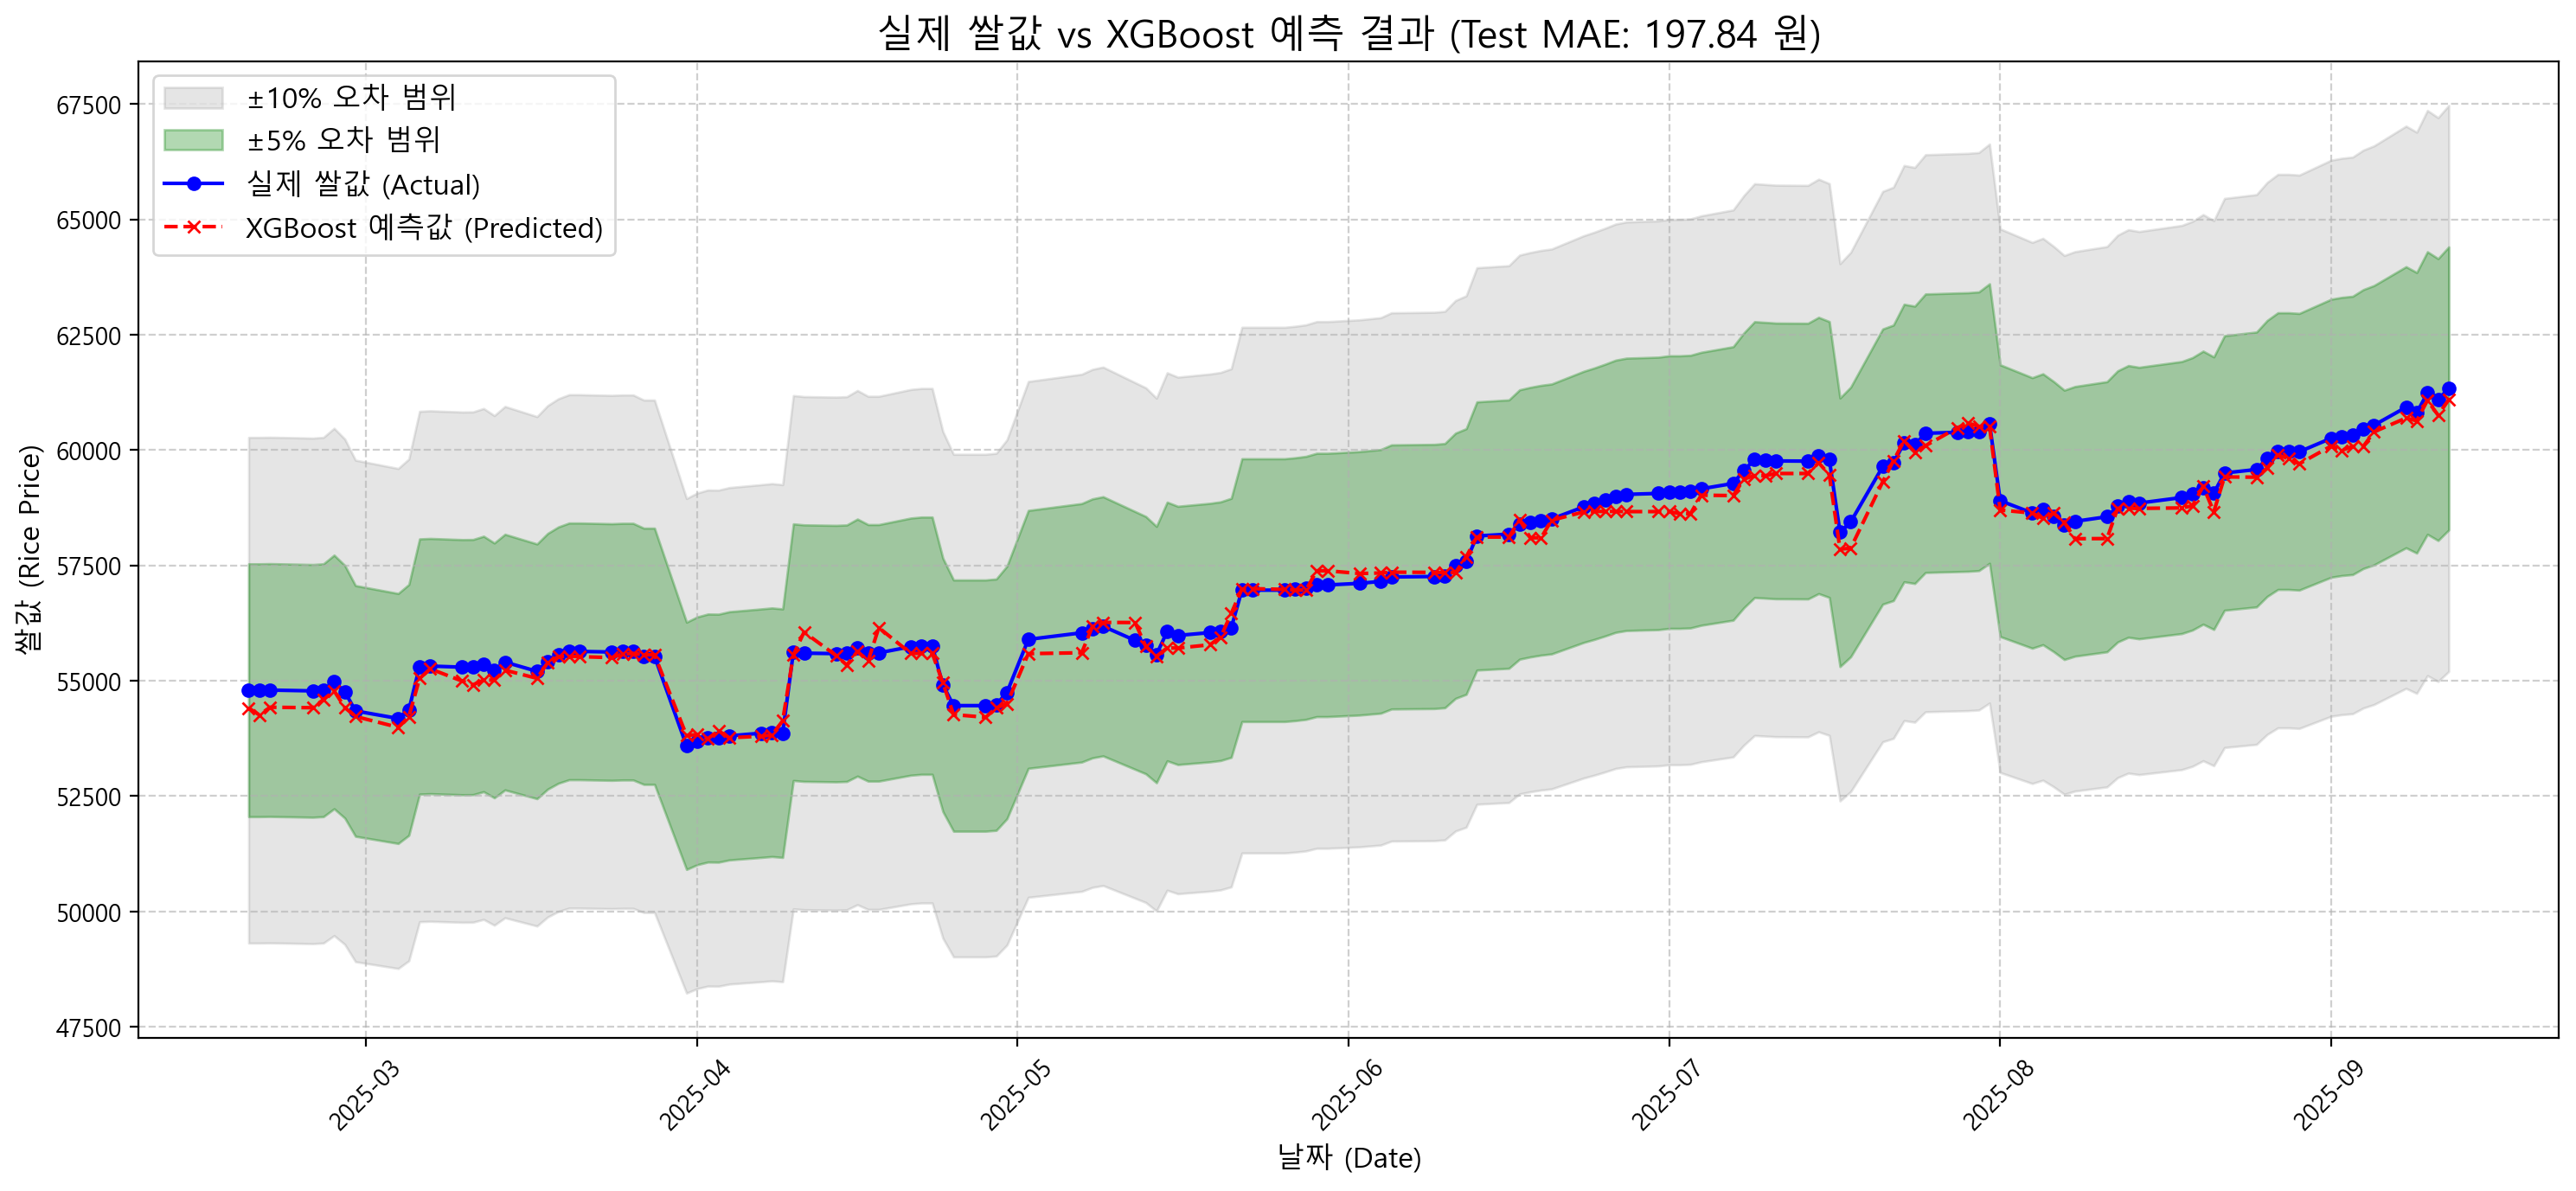

In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# 한글 폰트 설정 (Windows: Malgun Gothic, Mac: AppleGothic)
try:
    font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    plt.rc('font', family=font_name)
except FileNotFoundError:
    print("Malgun Gothic font not found... using default font.")
# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# --- 시각화 ---
plt.figure(figsize=(15, 7))

# [추가] 허용 오차 밴드 계산
# fill_between 함수는 Series나 1D 배열을 필요로 하므로, y값을 1차원으로 만듭니다.
actual_prices = xgb_test_y.values.flatten()
upper_10 = actual_prices * 1.10
lower_10 = actual_prices * 0.90
upper_5 = actual_prices * 1.05
lower_5 = actual_prices * 0.95

# [추가] 허용 오차 밴드 시각화 (라인 플롯보다 먼저 그려서 배경처럼 보이게 함)
# 10% 오차 밴드
plt.fill_between(xgb_test_df['날짜'], lower_10, upper_10, color='gray', alpha=0.2, label='±10% 오차 범위')
# 5% 오차 밴드
plt.fill_between(xgb_test_df['날짜'], lower_5, upper_5, color='green', alpha=0.3, label='±5% 오차 범위')

# 실제 값
plt.plot(xgb_test_df['날짜'], xgb_test_y, label='실제 쌀값 (Actual)', color='blue', marker='o', linestyle='-', markersize=5, zorder=3)

# XGBoost 예측 값
plt.plot(xgb_test_df['날짜'], xgboost_predictions, label='XGBoost 예측값 (Predicted)', color='red', marker='x', linestyle='--', markersize=5, zorder=3)

# 그래프 제목에 최종 RMSE 성능 지표 추가
plt.title(f'실제 쌀값 vs XGBoost 예측 결과 (Test MAE: {xgboost_mae:.2f} 원)', fontsize=16)
plt.xlabel('날짜 (Date)', fontsize=12)
plt.ylabel('쌀값 (Rice Price)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()